In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import string
import spacy
import nltk 
import re


from sklearn.ensemble import *
from nltk.stem import WordNetLemmatizer 
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


sns.set(style='whitegrid')

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/overview-of-recordings.csv', encoding="latin-1")


In [ ]:
df.head()

,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id
0,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,43453425,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495
1,light_clipping,0.6803,no_noise,0.6803,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,44088126
2,no_clipping,1.0000,no_noise,0.6655,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,44292353
3,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,31349958,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,43755034
4,no_clipping,1.0000,no_noise,1.0000,4.67,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,21665495


In [ ]:
def explore_data(df):
    print(f"The data contains {df.shape[0]} rows and {df.shape[1]} columns.")
    print('\n')
    print('Dataset columns:',df.columns)
    print('\n')
    print(df.info())

explore_data(df)

The data contains 6661 rows and 13 columns.


Dataset columns: Index(['audio_clipping', 'audio_clipping:confidence',
       'background_noise_audible', 'background_noise_audible:confidence',
       'overall_quality_of_the_audio', 'quiet_speaker',
       'quiet_speaker:confidence', 'speaker_id', 'file_download', 'file_name',
       'phrase', 'prompt', 'writer_id'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6661 entries, 0 to 6660
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   audio_clipping                       6661 non-null   object 
 1   audio_clipping:confidence            6661 non-null   float64
 2   background_noise_audible             6661 non-null   object 
 3   background_noise_audible:confidence  6661 non-null   float64
 4   overall_quality_of_the_audio         6661 non-null   float64
 5   quiet_speaker                      

In [ ]:
df.isna().sum()


audio_clipping                         0
audio_clipping:confidence              0
background_noise_audible               0
background_noise_audible:confidence    0
overall_quality_of_the_audio           0
quiet_speaker                          0
quiet_speaker:confidence               0
speaker_id                             0
file_download                          0
file_name                              0
phrase                                 0
prompt                                 0
writer_id                              0
dtype: int64

In [ ]:
def checking_removing_duplicates(df):
    count_dups = df.duplicated().sum()
    if count_dups >= 1:
        df.drop_duplicates(inplace=True)
        print("Number of Duplicates: ", count_dups)
        print('Duplicate values removed!')
    else:
        print('No Duplicate values')
checking_removing_duplicates(df)

No Duplicate values


In [ ]:
df_text = df[['phrase', 'prompt']]
df_text

,phrase,prompt
0,When I remember her I feel down,Emotional pain
1,When I carry heavy things I feel like breaking...,Hair falling out
2,there is too much pain when i move my arm,Heart hurts
3,My son had his lip pierced and it is swollen a...,Infected wound
4,My muscles in my lower back are aching,Infected wound
...,...,...
6656,I feel a burning sensation in my guts about 2 ...,Stomach ache
6657,I have a split on my thumb that will not heal.,Open wound
6658,I feel a lot of pain in the joints.,Joint pain
6659,The area around my heart doesn't feel good.,Heart hurts


In [ ]:
def clean_txt(docs):
    lemmatizer = WordNetLemmatizer() 
    # split into words
    speech_words = nltk.word_tokenize(docs)
    # convert to lower case
    lower_text = [w.lower() for w in speech_words]
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in lower_text]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in  list(STOP_WORDS)]
    #Stemm all the words in the sentence
    lem_words = [lemmatizer.lemmatize(word) for word in words]
    combined_text = ' '.join(lem_words)
    return combined_text

In [ ]:
def classification_metrics(model, y_test, y_pred):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    fig,ax = plt.subplots(figsize=(8,6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion matrix for Logisitic Regression Model', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    print(classification_report(y_test, y_pred))

In [ ]:
def save_model(model,filename):
    pickle.dump(model, open(filename, 'wb'))

In [ ]:
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df_text['phrase'] = df_text['phrase'].apply(clean_txt)

In [ ]:
df_text['phrase']

0                                           remember feel
1                    carry heavy thing feel like breaking
2                                                pain arm
3       son lip pierced swollen skin inside lip grey l...
4                                     muscle lower aching
                              ...                        
6656                 feel burning sensation gut hour meal
6657                                     split thumb heal
6658                                  feel lot pain joint
6659                              area heart nt feel good
6660                           complain alot skin allergy
Name: phrase, Length: 6661, dtype: object

In [ ]:
X = df['phrase']
y = df['prompt']


In [ ]:
X.head()

0                      When I remember her I feel down
1    When I carry heavy things I feel like breaking...
2            there is too much pain when i move my arm
3    My son had his lip pierced and it is swollen a...
4               My muscles in my lower back are aching
Name: phrase, dtype: object

In [ ]:
y.head()

0      Emotional pain
1    Hair falling out
2         Heart hurts
3      Infected wound
4      Infected wound
Name: prompt, dtype: object

In [ ]:
vec = TfidfVectorizer()

In [ ]:
X = vec.fit_transform(X).toarray()

In [ ]:
X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
prompt = df_text["prompt"].unique()
prompt_dict = {value:index for index, value in enumerate(prompt)}
results = df_text["prompt"].map(prompt_dict)
print(f'\n{prompt_dict}\n')


{'Emotional pain': 0, 'Hair falling out': 1, 'Heart hurts': 2, 'Infected wound': 3, 'Foot ache': 4, 'Shoulder pain': 5, 'Injury from sports': 6, 'Skin issue': 7, 'Stomach ache': 8, 'Knee pain': 9, 'Joint pain': 10, 'Hard to breath': 11, 'Head ache': 12, 'Body feels weak': 13, 'Feeling dizzy': 14, 'Back pain': 15, 'Open wound': 16, 'Internal pain': 17, 'Blurry vision': 18, 'Acne': 19, 'Muscle pain': 20, 'Neck pain': 21, 'Cough': 22, 'Ear ache': 23, 'Feeling cold': 24}



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, results, test_size=0.3, random_state=0)

Training Accuracy Score: 99.8%
Validation Accuracy Score: 99.5%


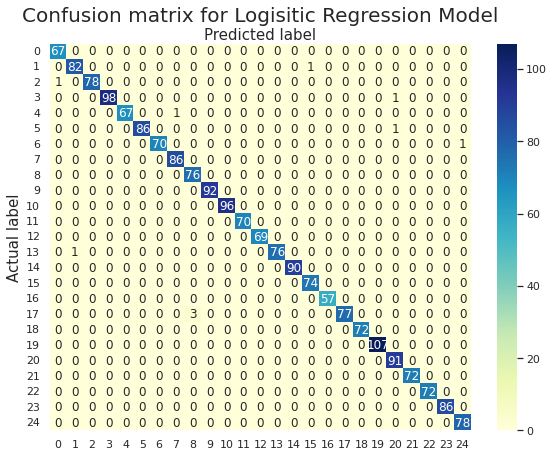

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        67
           1       0.99      0.99      0.99        83
           2       1.00      0.99      0.99        79
           3       1.00      0.99      0.99        99
           4       1.00      0.99      0.99        68
           5       1.00      0.99      0.99        87
           6       1.00      0.99      0.99        71
           7       0.99      1.00      0.99        86
           8       0.96      1.00      0.98        76
           9       1.00      1.00      1.00        92
          10       1.00      1.00      1.00        96
          11       1.00      1.00      1.00        70
          12       1.00      1.00      1.00        69
          13       1.00      0.99      0.99        77
          14       1.00      1.00      1.00        90
          15       0.99      1.00      0.99        74
          16       1.00      1.00      1.00        57
          17       1.00    

In [ ]:
text_clf = BaggingClassifier(n_estimators=10)
model = text_clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
classification_metrics(model, y_test, y_pred)

In [ ]:
save_model(model, 'model.pkl')

save_model(vec, 'vectorizer.pkl')

In [ ]:
def detectAilment(text):
    pred = [text]

    transform_vect =vec.transform(pred).toarray()
    if model.predict(transform_vect) == 0:
        print("Emotional pain")
    elif model.predict(transform_vect) == 1:
        print("Hair falling out")
    elif model.predict(transform_vect) == 2:
        print("Heart hurts")
    elif model.predict(transform_vect) == 3:
        print("Infected wound")
    elif model.predict(transform_vect) == 4:
        print("Foot achne")
    elif model.predict(transform_vect) == 5:
        print("Shoulder pain")
    elif model.predict(transform_vect) == 6:
        print("Injury from sports")
    elif model.predict(transform_vect) == 7:
        print("Skin issue")
    elif model.predict(transform_vect) == 8:
        print("Stomach ache")
    elif model.predict(transform_vect) == 9:
        print("Knee pain")
    elif model.predict(transform_vect) == 10:
        print("Joint pain")
    elif model.predict(transform_vect) == 11:
        print("Hard to breath")
    elif model.predict(transform_vect) == 12:
        print("Head ache")
    elif model.predict(transform_vect) == 13:
        print("Body feels weak")
    elif model.predict(transform_vect) == 14:
        print("Feeling Dizzy")
    elif model.predict(transform_vect) == 15:
        print("Back pain")
    elif model.predict(transform_vect) == 16:
        print("Open wound")
    elif model.predict(transform_vect) == 17:
        print("Internal pain")
    elif model.predict(transform_vect) == 18:
        print("Blurry vision")
    elif model.predict(transform_vect) == 19:
        print("Acne")
    elif model.predict(transform_vect) == 20:
        print("Muscle pain")
    elif model.predict(transform_vect) == 21:
        print("Neck pain")
    elif model.predict(transform_vect) == 22:
        print("Cough")
    elif model.predict(transform_vect) == 23:
        print("Ear ache")
        
    else:
        print("Feeling cold")


In [ ]:
for i in (0,3):
    value = input('How are you feeling right now?:')
    detectAilment(value)

How are you feeling right now?:I am feeling breathless 
Stomach ache
How are you feeling right now?:Pain in my back
Back pain


In [ ]:
my_data=input("Enter the text:")

Enter the text:I am going to pee frequently


In [ ]:
my_transform_vect =vec.transform([my_data]).toarray()

In [ ]:
prediction=model.predict(my_transform_vect)
print(prediction)

[13]


In [ ]:
detectAilment(my_data)

Body feels weak
